#### Shrivu Shankar (ss86692)

## Data Collection

As part of my work in UT Austin's [Computational Media Lab](http://computationalmedialab.com/), I've been scraping ([code](https://github.com/sshh12/venmo-research)) millions of Venmo transactions and users from Venmno's publically facing API. The data scraped is stored in a local SQL database that I query here to extract sample statistics. I will make the assumption that my sample is less than 10% of the total number of Venmo transactions and that whether a not a user or transaction is returned by the API is independent of any properties of the user or transaction. These assumptions may conflict with the results found as a part of the full research project and are only made to simplify the use of the dataset for this specific assignment.

In [1]:
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import psycopg2
import pickle
import emoji
import os
import re

%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
def connect():
    conn = psycopg2.connect(
        user="postgres",
        password=os.environ.get("POSTGRES_PASS", ""),
        host="localhost",
        port=5432,
        database="venmo",
    )
    return conn

meta = Counter()
emoji_cnt = Counter()
emoji_usage = Counter()
actor_transactions = Counter()
day_of_week = Counter()
hour_of_day = Counter()

conn = connect()
with conn.cursor(name="m358k") as cursor:
    cursor.itersize = 2000
    cursor.execute("SELECT id, message, created, actor_user_id FROM transactions")
    for i, (id_, msg, created, actor_id) in enumerate(cursor):
        meta["msgs"] += 1
        day_of_week[created.weekday()] += 1
        hour_of_day[created.hour] += 1
        actor_transactions[actor_id] += 1
        emojis = [c for c in str(msg) if c in emoji.UNICODE_EMOJI]
        emoji_cnt[len(emojis)] += 1
        for em in emojis:
            emoji_usage[em] += 1


with open("m358k_ckpt.pkl", "wb") as fp:
    pickle.dump(
        (meta, emoji_cnt, emoji_usage, actor_transactions, day_of_week, hour_of_day), fp
    )

conn.close()

## Data Exploration

Some charts to get a feel for the data.

In [2]:
with open("m358k_ckpt.pkl", "rb") as fp:
    (
        meta,
        emoji_cnt,
        emoji_usage,
        actor_transactions,
        day_of_week,
        hour_of_day,
    ) = pickle.load(fp)

# turn transactions per user into num users for each # of transactions
user_transaction_cnts = Counter()
for user, num_sent in actor_transactions.items():
    user_transaction_cnts[num_sent] += 1

<IPython.core.display.Javascript object>

In [3]:
print(meta["msgs"], "transactions found and", len(actor_transactions), "unique users")

135900627 transactions found and 16527360 unique users


<IPython.core.display.Javascript object>

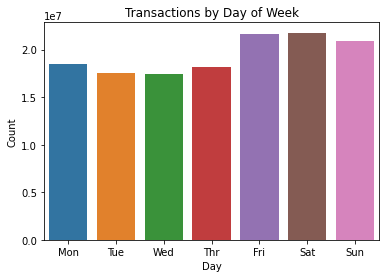

<IPython.core.display.Javascript object>

In [4]:
df = (
    pd.DataFrame.from_dict(day_of_week, orient="index")
    .reset_index()
    .rename(columns={"index": "Day", 0: "Count"})
)
fig = sns.barplot(x=df["Day"], y=df["Count"])
fig.set_title("Transactions by Day of Week")
_ = fig.set_xticklabels(["Mon", "Tue", "Wed", "Thr", "Fri", "Sat", "Sun"])

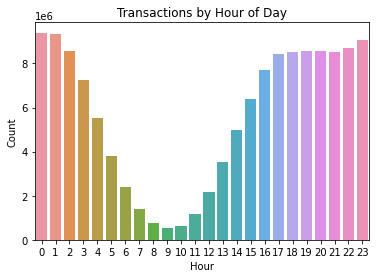

<IPython.core.display.Javascript object>

In [5]:
# don't actually know what timezone this is in, but can probably be assumed to be Pacific Time
df = (
    pd.DataFrame.from_dict(hour_of_day, orient="index")
    .reset_index()
    .rename(columns={"index": "Hour", 0: "Count"})
)
_ = sns.barplot(x=df["Hour"], y=df["Count"]).set_title("Transactions by Hour of Day")

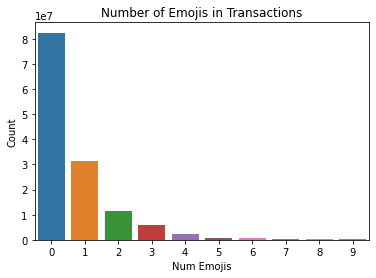

<IPython.core.display.Javascript object>

In [7]:
df = (
    pd.DataFrame.from_dict(emoji_cnt, orient="index")
    .reset_index()
    .rename(columns={"index": "Num Emojis", 0: "Count"})
)
df = df[df["Num Emojis"] < 10]
_ = sns.barplot(x=df["Num Emojis"], y=df["Count"]).set_title(
    "Number of Emojis in Transactions"
)

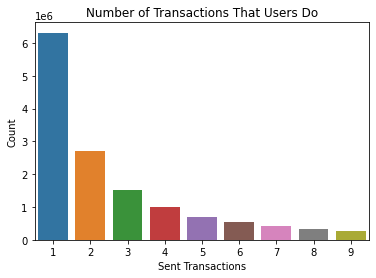

<IPython.core.display.Javascript object>

In [8]:
df = (
    pd.DataFrame.from_dict(user_transaction_cnts, orient="index")
    .reset_index()
    .rename(columns={"index": "Sent Transactions", 0: "Count"})
)
df = df[df["Sent Transactions"] < 10]
_ = sns.barplot(x=df["Sent Transactions"], y=df["Count"]).set_title(
    "Number of Transactions That Users Do"
)

## Confidence Interval: Mean Transactions Per User

In [9]:
transactions = []
for t_cnt, cnt in user_transaction_cnts.items():
    transactions.extend([t_cnt] * cnt)
print(
    "x mean =",
    np.mean(transactions),
    "stddev =",
    np.std(transactions, ddof=1),
    "n =",
    len(transactions),
)

x mean = 8.222766793970726 stddev = 56.29812972663279 n = 16527360


<IPython.core.display.Javascript object>

$CI_{99\%} = 8.2228 \pm 2.576 \frac{56.2981}{\sqrt{16527360}} = (8.1871, 8.2584)$

## Confidence Interval: Proportion of Transactions With Emojis

In [10]:
emojis = []
for e_cnt, cnt in emoji_cnt.items():
    if e_cnt == 0:
        emojis.extend([0] * cnt)
    else:
        emojis.extend([1] * cnt)
print(
    "p =",
    np.mean(emojis),
    "n =",
    len(emojis),
)

p = 0.3935647257904116 n = 135900627


<IPython.core.display.Javascript object>

$CI_{99\%} = 0.3936 \pm 2.576 \sqrt{\frac{0.3935(1-0.3935)}{135900627}} = (0.3935, 0.3937)$

## Test: GoF Transactions and Day of Week

$$H_0: \text{There is no association between day of the week and user transactions}, H_a: \text{There is an association}$$

In [11]:
expected = []
observed = []
for i in range(7):
    expected.append(round(sum(day_of_week.values()) / 7))
    observed.append(day_of_week[i])
print("expected = ", expected)
print("observed = ", observed)
print("df = ", len(expected) - 1)

expected =  [19414375, 19414375, 19414375, 19414375, 19414375, 19414375, 19414375]
observed =  [18454391, 17572686, 17455729, 18148538, 21603216, 21776043, 20890024]
df =  6


<IPython.core.display.Javascript object>

$\chi^2 = 1.148*10^{6}, \text{p-value} \approx 0$